In the past I binned cell lines by ancestry group, then calculated differential dependencies between all of the bins.

Rameen had the *excellent* suggestion to bin cell lines by the ancestry at each specific genetic locus. So comparing cell lines with "EUR" EGFR vs "EAS" EGFR, for example.

This will require recomputing half of the paper. But I do think it will make the paper better. I will admit that, even if I don't want to.

In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(janitor)
library(ggrepel)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




# As a first step, we need to figure out where each gene is in the genome.

I think that this part will be very tricky, because there are a few things that we need to consider.

First, a single gene may span two RFMix blocks. How do we deal with this? In most cases adjacent blocks will probably be the same ancestry group, so I think any solution we pick will probably be okay, as long as we can justify it.

In [2]:
#Load in the hg38 refGene gene annotations. These were downloaded from ucsc genome browser on 6.22.22.
#https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/genes/hg38.refGene.gtf.gz
#Then process them so that we have a chr and position for each gene 

setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
refgene = read.table("hg38.refGene.gtf", header = F, sep = "\t") %>%
select(V1, V3, V4, V5, 7, V9) %>%
rename("chr" = V1, "type" = V3, "start" = V4, "end" = V5, "strand" = V7, "gene" = V9) %>%
filter(type %in% "transcript") %>%
mutate("position" = ifelse(strand %in% "+", start, end)) %>%
mutate(gene = gsub(";..*", "", gene)) %>%
mutate(gene = gsub("gene_id ", "", gene)) %>%
select(chr, position, gene)

head(refgene)

,chr,position,gene
,<chr>,<int>,<chr>
1,chr1,11874,DDX11L1
2,chr1,29370,WASH7P
3,chr1,17436,MIR6859-1
4,chr1,17436,MIR6859-2
5,chr1,17436,MIR6859-3
6,chr1,17436,MIR6859-4


# Load in the RFMix data so that we know the ancestry group for each block

Load in all of the rfmix data, then create a matrix where columns are cell lines and rows are genes. The data in the matrix is the ancestry group for each gene.

In [2]:
#Load the RFMix data into one big df.
setwd("/home/jupyter/Ancestry/rfmix")
rfmix.file.names = list.files(pattern = "msp.tsv")

rfmix.data = NULL
for(rfmix.file in rfmix.file.names){
    rfmix.data.temp = read.table(rfmix.file, sep = "\t", header = T, comment.char = "^", skip = 1)
    rfmix.data = rbind(rfmix.data, rfmix.data.temp)
}

rfmix.data = rfmix.data %>%
select(X.chm, spos, epos, contains(".1")) 

head(rfmix.data)

,X.chm,spos,epos,ACH.000657.1,ACH.000617.1,ACH.000685.1,ACH.000632.1,ACH.000171.1,ACH.000863.1,ACH.000971.1,⋯,ACH.000981.1,ACH.000217.1,ACH.000116.1,ACH.000930.1,ACH.000986.1,ACH.000342.1,ACH.001130.1,ACH.000287.1,ACH.000798.1,ACH.000645.1
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1,54490,1167183,0,3,0,3,3,3,3,⋯,3,2,3,0,3,3,0,3,3,3
2,chr1,1167183,1639348,0,3,0,3,3,3,3,⋯,3,2,3,0,3,3,0,3,3,3
3,chr1,1639348,1703754,0,3,0,3,3,3,3,⋯,3,2,3,0,3,3,2,3,3,3
4,chr1,1703754,1714987,0,3,0,3,3,3,3,⋯,3,2,3,0,3,3,2,3,3,3
5,chr1,1714987,1896915,0,3,0,3,3,3,3,⋯,3,2,3,0,3,3,2,3,3,3
6,chr1,1896915,1960886,0,3,0,3,3,3,3,⋯,3,2,3,0,3,3,2,3,3,3


# Figure out which block each gene falls in and assemble a matrix

In [4]:
#Annotate rfmix data so that it each row has an (arbitrary) block ID
block_ids = paste("block", seq(1:nrow(rfmix.data)), sep = "") #build a vector of block IDs

rfmix.data = rfmix.data %>%
mutate(block_id = block_ids, .before = X.chm)
head(rfmix.data)

,block_id,X.chm,spos,epos,ACH.000657.1,ACH.000617.1,ACH.000685.1,ACH.000632.1,ACH.000171.1,ACH.000863.1,⋯,ACH.000981.1,ACH.000217.1,ACH.000116.1,ACH.000930.1,ACH.000986.1,ACH.000342.1,ACH.001130.1,ACH.000287.1,ACH.000798.1,ACH.000645.1
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,block1,chr1,54490,1167183,0,3,0,3,3,3,⋯,3,2,3,0,3,3,0,3,3,3
2,block2,chr1,1167183,1639348,0,3,0,3,3,3,⋯,3,2,3,0,3,3,0,3,3,3
3,block3,chr1,1639348,1703754,0,3,0,3,3,3,⋯,3,2,3,0,3,3,2,3,3,3
4,block4,chr1,1703754,1714987,0,3,0,3,3,3,⋯,3,2,3,0,3,3,2,3,3,3
5,block5,chr1,1714987,1896915,0,3,0,3,3,3,⋯,3,2,3,0,3,3,2,3,3,3
6,block6,chr1,1896915,1960886,0,3,0,3,3,3,⋯,3,2,3,0,3,3,2,3,3,3


In [ ]:
#Loop through all of the genes in 'refgene' and calculate which block each gene falls in
block.assignment = refgene %>% apply(1, function(x){
    
    #First filter the rfmix data by chromosome
    rfmix.chr.filtered = rfmix.data %>%
    filter(X.chm %in% x[1])
    
    #Calculate if the gene of interest is between the start and end position of the rfmix block
    between.vector = rfmix.chr.filtered %>% apply(1, function(y){
        between(y[4], y[5], x[2])
    })
    
    #Now get the block for each gene
    is.true = between.vector[between.vector == TRUE] %>% length()
    
    if(is.true >= 1){
        block = rfmix.chr.filtered %>%
        pull(block_id) %>%
        .[is.true]
    } else {
        block = "NA"
    }
    
    return(block)
    
})

In [ ]:
#Add the block assignment to the refgene object
refgene = refgene %>%
mutate("block.assignment" = block.assignment)

tail(refgene)

In [ ]:
#Now assemble the matrix
#In this code I will go through each row in 
gene.block.matrix = refgene %>%
filter(block.assignment != "NA") %>%
distinct(gene, .keep_all = TRUE) %>%
apply(1, function(x){
    
    #Get the block of interest for this loop
    block.of.interest = x[4] #This is the block for this iteration of the loop
    gene.of.interest = x[3] #This is the gene for this interation of the loop
    
    #Filter the row of rfmix.data that has that block
    rfmix.block = rfmix.data %>%
    filter(block_id %in% block.of.interest)
    
    #Add the gene of interest
    final.output = c(gene.of.interest, rfmix.block) #Add the rfmix gene to that row
    
    #Export it from the apply loop
    return(final.output)
}) %>%
map_dfr(as.list) #Convert it all to a matrix

In [ ]:
#Now export the gene block matrix so that I can use it in other downstream analysis
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
write.table(gene.block.matrix, "gene.block.matrix.txt", sep = "\t", col.names = T, quote = F)

In [2]:
#Load in the gene block matrix to save a bunch of compute time if I ever need to re-make the figure
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

# Now let's test to see if there are any ancestry-associated genetic dependencies

In [ ]:
#Load in the chronos data and format it
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
ccle.chronos = read.table('CRISPR_gene_effect_22Q1.csv', sep = ",", header = T, check.names = FALSE) %>%
rename( "sample" = 1) %>%
setNames(word(names(.), 1)) 
head(ccle.chronos)

In [4]:
head(gene.block.matrix)

,gene,block_id,X.chm,spos,epos,ACH.000657.1,ACH.000617.1,ACH.000685.1,ACH.000632.1,ACH.000171.1,⋯,ACH.000981.1,ACH.000217.1,ACH.000116.1,ACH.000930.1,ACH.000986.1,ACH.000342.1,ACH.001130.1,ACH.000287.1,ACH.000798.1,ACH.000645.1
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,TGIF1,block5021,chr18,3408705,3446621,0,3,0,3,3,⋯,3,2,3,0,3,3,2,3,3,3
2,PRDX6,block628,chr1,173328576,173406706,0,3,0,3,3,⋯,3,2,3,0,3,3,2,3,3,3
3,CIC,block5676,chr19,41793296,41963821,0,3,3,3,3,⋯,3,2,3,0,3,3,2,3,3,3
4,PLEC,block12479,chr8,143617922,143895192,0,3,0,3,3,⋯,3,2,3,0,3,3,2,3,3,3
5,MPP2,block4765,chr17,43227219,43693672,0,3,0,3,3,⋯,3,2,3,3,3,3,2,3,3,3
6,CFTR,block11554,chr7,117234417,117278031,0,3,0,3,3,⋯,3,2,3,0,3,3,2,3,3,3


In [5]:
#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))


head(formatted.gene.block.matrix)

,sample,TGIF1,PRDX6,CIC,PLEC,MPP2,CFTR,C1QB,ELN,SEPTIN12,⋯,GTF2H2C,TTC31,PDE8B,CHD1,PAK1,LOC284898,PRKD3,MLC1,ZBTB41,TMEM181
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000657,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000617,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,0,3
3,ACH-000685,0,0,3,0,0,0,0,0,3,⋯,0,0,0,0,0,0,0,3,0,2
4,ACH-000632,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000171,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000863,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


In [6]:
#Filter both datasets so that they share a common set of samples
intersecting.samples = intersect(ccle.chronos$sample, formatted.gene.block.matrix$sample)
intersecting.genes = intersect(colnames(ccle.chronos), colnames(formatted.gene.block.matrix))

final.ccle.chronos = ccle.chronos %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

final.gene.block = formatted.gene.block.matrix %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

head(final.ccle.chronos)
head(final.gene.block)

dim(final.ccle.chronos)
dim(final.gene.block)

,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.016751717,-0.4675348,-0.05643839,-0.1176586,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.141819984,0.1195287,-0.10724648,-0.2477974,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.304217262,-0.1466795,-0.05148461,-0.3344562,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.195726053,-0.2546972,-0.27257956,-0.4733824,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,0.028096552,-0.1723441,-0.18239415,-0.3284529,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000012,-0.10647815,0.01288647,0.16741875,0.227102498,0.07689544,-0.21553977,0.18137996,-0.1281190,0.004292332,⋯,-0.001588165,-0.1282899,-0.53368428,-1.1187548,0.06429254,0.05243090,-0.04087758,-0.075470757,-0.03858331,-0.24810776


,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000001,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
2,ACH-000004,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
3,ACH-000005,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
4,ACH-000007,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000009,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000012,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


[1]   611 16385

[1]   611 16385

Now it's time to loop through everything and calculate the ancestry associations

AFR = 0
AMR = 1
EAS = 2
EUR = 3
SAS = 4

Such ugly code. Oh my gosh. I am ashamed. But I just need to get this done.

In [ ]:
#Calculate p-values and mean differences

gene.names = colnames(final.gene.block)[2:ncol(final.gene.block)]

afr.pval.vector = NULL
amr.pval.vector = NULL
eas.pval.vector = NULL
eur.pval.vector = NULL
sas.pval.vector = NULL
afr.mean.dif = NULL
amr.mean.dif = NULL
eas.mean.dif = NULL
eur.mean.dif = NULL
sas.mean.dif = NULL
for(gene in gene.names){
        
   #Filter the chronos data so that it only includes the gene we are interested in 
   chronos.filtered = final.ccle.chronos %>% select(sample, all_of(gene))
    
   #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = wilcox.test(afr.chronos, non.afr.chronos)$p.value
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = wilcox.test(amr.chronos, non.amr.chronos)$p.value 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = wilcox.test(eas.chronos, non.eas.chronos)$p.value 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = wilcox.test(eur.chronos, non.eur.chronos)$p.value 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = wilcox.test(sas.chronos, non.sas.chronos)$p.value 
    } else { sas.pval = 1 }
    

    
    #Add the p-values to the vector outside of the loop
    afr.pval.vector = c(afr.pval.vector, afr.pval)
    amr.pval.vector = c(amr.pval.vector, amr.pval)
    eas.pval.vector = c(eas.pval.vector, eas.pval)
    eur.pval.vector = c(eur.pval.vector, eur.pval)
    sas.pval.vector = c(sas.pval.vector, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif = c(afr.mean.dif, afr.dif)
    amr.mean.dif = c(amr.mean.dif, amr.dif)
    eas.mean.dif = c(eas.mean.dif, eas.dif)
    eur.mean.dif = c(eur.mean.dif, eur.dif)
    sas.mean.dif = c(sas.mean.dif, sas.dif)
}

In [ ]:

#First, create datasets for each ancestry group, then cat them.
afr.volcano.df = cbind(gene.names, afr.pval.vector, afr.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AFR")

amr.volcano.df = cbind(gene.names, amr.pval.vector, amr.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AMR")

eas.volcano.df = cbind(gene.names, eas.pval.vector, eas.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EAS")

eur.volcano.df = cbind(gene.names, eur.pval.vector, eur.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EUR")

sas.volcano.df = cbind(gene.names, sas.pval.vector, sas.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "SAS")

cat.volcano.df = rbind(afr.volcano.df, amr.volcano.df, eas.volcano.df, eur.volcano.df, sas.volcano.df) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(difference = as.numeric(difference)) %>%
mutate(FDR = p.adjust(pval, method = "BH", n = length(pval)))

head(cat.volcano.df)
tail(cat.volcano.df)

setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
write.table(cat.volcano.df, "ancestry_locus_gene_associations.txt", sep = "\t", col.names = T, row.names = F)

In [1]:
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
cat.volcano.df = read.table("ancestry_locus_gene_associations.txt", sep = "\t", header = T)
head(cat.volcano.df)

,gene,pval,difference,ancestry,FDR
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,A1BG,0.07814048,0.018967685,AFR,0.9259430
2,A1CF,0.08035465,-0.035117475,AFR,0.9270243
3,A2M,0.58861022,-0.010031350,AFR,1.0000000
4,A2ML1,0.82034442,0.009988105,AFR,1.0000000
5,A3GALT2,0.96604057,0.003320528,AFR,1.0000000
6,A4GALT,0.87594000,0.004528391,AFR,1.0000000


In [3]:
#Now get a list of the significant genes and calculate the number of significant genes for each ancestry group
significant.genes = cat.volcano.df %>%
filter(FDR < 0.05) %>%
pull(gene) %>%
unique()
significant.genes %>% length()

#Now calculate the number of significant genes for each ancestry group
sig.genes.per.group = cat.volcano.df %>%
filter(FDR < 0.05) %>%
group_by(ancestry) %>%
summarise(n = n())
sig.genes.per.group

[1] 98

ancestry,n
<chr>,<int>
AFR,19
AMR,2
EAS,65
EUR,56


Warning message:
“Removed 428 rows containing missing values (geom_point).”
Warning message:
“Removed 428 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 428 rows containing missing values (geom_point).”
Warning message:
“Removed 428 rows containing missing values (geom_text_repel).”


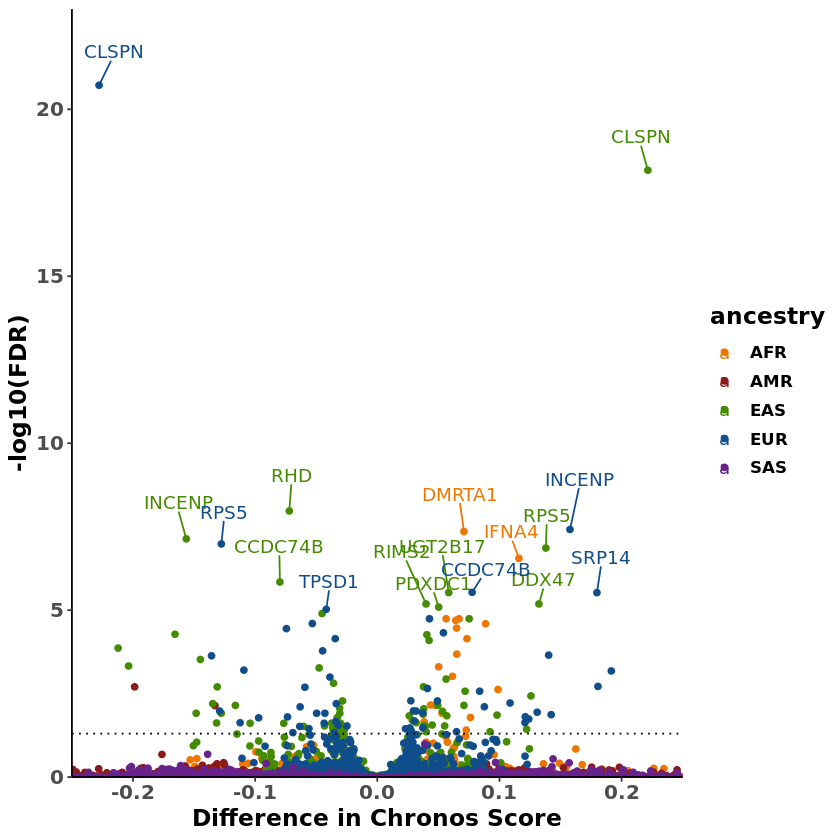

In [4]:
#Create the color vector
group.colors <- c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")

#Now finally plot the volcano plot
cat.volcano.df %>%
ggplot(aes(x = difference, y = -log10(FDR), color = ancestry)) +
geom_point(aes(x = difference, y = -log10(FDR), color = ancestry)) +
geom_hline(linetype = "dotted", yintercept = 1.301) +

theme_bw() +
scale_colour_manual(values = group.colors) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylab("-log10(FDR)") +
xlab("Difference in Chronos Score") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0), limits = c(0, 23)) +
scale_x_continuous(expand = c(0,0), limits = c(-0.25, 0.25)) +

geom_text_repel(
aes(label=ifelse(-log10(FDR) > 5, 
as.character(gene),'')), 
box.padding = 0.5,
nudge_y = 1,
segment.ncp = 3,
segment.angle = 20)

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("locus_volcanoplot.pdf", width = 8, height = 8)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp locus_volcanoplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Generate the GRB2 SHP2 supplemental figure

Two interesting genes from the above analysis are SHP2 and GRB2. Let's make a supplemental figure that highlights these two genes.

AFR = 0 AMR = 1 EAS = 2 EUR = 3 SAS = 4

In [10]:
#Grab PTPN11 and GRB2 from both data frames
chronos.shp2.ptpn11 = final.ccle.chronos %>% 
select(sample, PTPN11, GRB2) %>%
rename("chronos_ptpn11" = PTPN11, "chronos_grb2" = GRB2)

gene.block.shp2.ptpn11 = final.gene.block %>%
select(sample, PTPN11, GRB2) %>%
rename("block_ptpn11" = PTPN11, "block_grb2" = GRB2)

#merge the two datasets together
block.and.chronos = inner_join(chronos.shp2.ptpn11, gene.block.shp2.ptpn11, by = "sample")

head(block.and.chronos)

,sample,chronos_ptpn11,chronos_grb2,block_ptpn11,block_grb2
,<chr>,<dbl>,<dbl>,<int>,<int>
1,ACH-000001,-0.5175887,-0.3501043,3,3
2,ACH-000004,-0.7212404,-0.6487567,3,3
3,ACH-000005,-1.0170940,-0.6915075,3,0
4,ACH-000007,-0.7956095,-0.8175380,3,3
5,ACH-000009,-0.8889995,-1.3572802,3,3
6,ACH-000012,-1.2340947,-1.2756595,3,3


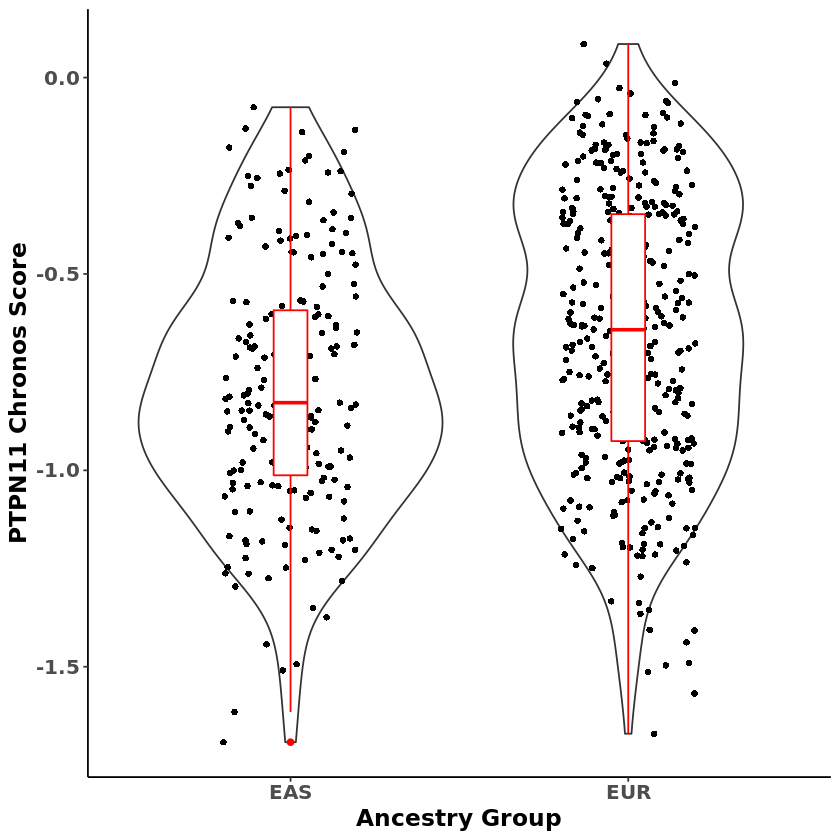

In [31]:
#Now generate the figure for ptpn11
block.and.chronos %>%
filter(block_ptpn11 %in% c("2", "3")) %>%
mutate(block_ptpn11 = gsub("2", "EAS", block_ptpn11)) %>%
mutate(block_ptpn11 = gsub("3", "EUR", block_ptpn11)) %>%
ggplot(aes(x = block_ptpn11, y = chronos_ptpn11, group = block_ptpn11)) +
geom_violin() +
geom_jitter(shape=16, position=position_jitter(0.2)) +
geom_boxplot(width=0.1, color = "red") +
theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylab("PTPN11 Chronos Score") +
xlab("Ancestry Group")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("ptpn11_violin.pdf", width = 4, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp ptpn11_violin.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

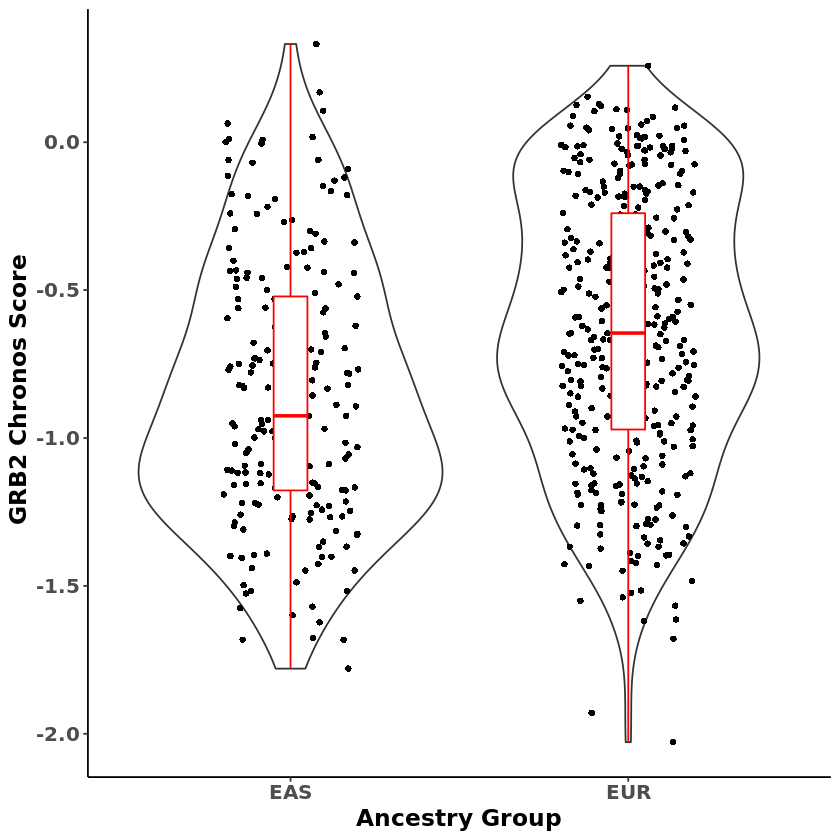

In [32]:
#Now generate the figure for grb2
block.and.chronos %>%
filter(block_grb2 %in% c("2", "3")) %>%
mutate(block_grb2 = gsub("2", "EAS", block_grb2)) %>%
mutate(block_grb2 = gsub("3", "EUR", block_grb2)) %>%
ggplot(aes(x = block_grb2, y = chronos_grb2, group = block_grb2)) +
geom_violin() +
geom_jitter(shape=16, position=position_jitter(0.2)) +
geom_boxplot(width=0.1, color = "red") +
theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylab(" GRB2 Chronos Score") +
xlab("Ancestry Group")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("grb2_violin.pdf", width = 4, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp grb2_violin.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Generate a volcano plot for just genes that are associated with AFR ancestry

Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing missing values (geom_text_repel).”


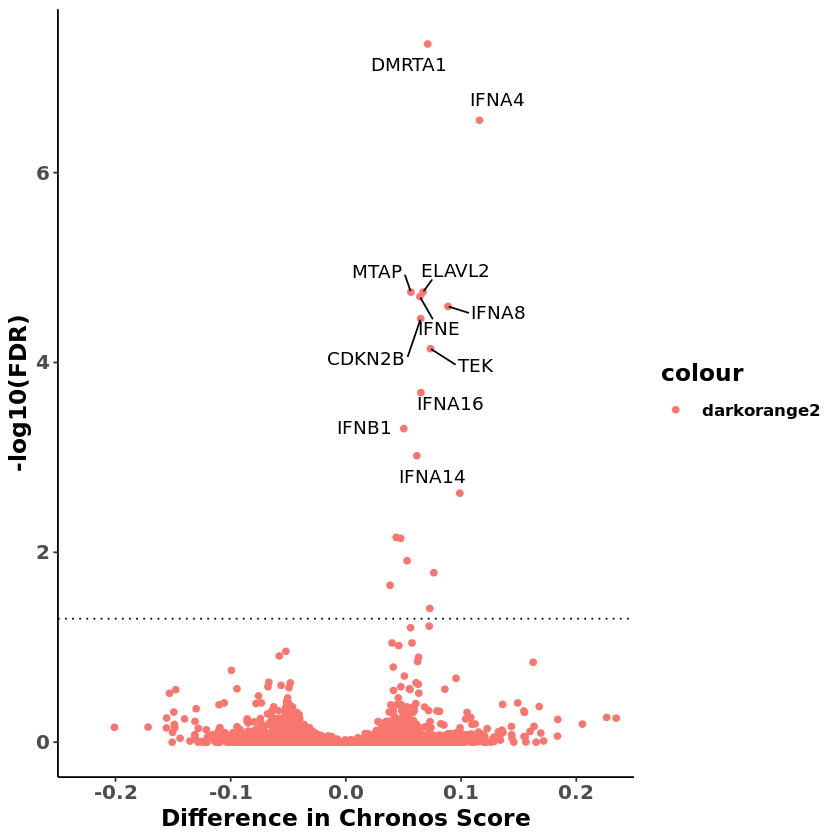

In [8]:
#Now finally plot the volcano plot
cat.volcano.df %>%
filter(ancestry %in% "AFR") %>%
ggplot(aes(x = difference, y = -log10(FDR), color = "darkorange2")) +
geom_point(aes(x = difference, y = -log10(FDR), color = "darkorange2")) +
geom_hline(linetype = "dotted", yintercept = 1.301) +

theme_bw() +


theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylab("-log10(FDR)") +
xlab("Difference in Chronos Score") +
labs(fill='Ancestry Group') +
scale_x_continuous(expand = c(0,0), limits = c(-0.25, 0.25)) +

geom_text_repel(
aes(label=ifelse(-log10(FDR) > 3, 
as.character(gene),'')), 
box.padding = 0.5,
color = "black",
segment.ncp = 3,
segment.angle = 20)

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("afr_locus_volcanoplot.pdf", width = 8, height = 8)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp afr_locus_volcanoplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))